In [1]:
#push!(LOAD_PATH,"julia/src/Simulation")
#import Simulation

┌ Info: Precompiling Simulation [top-level]
└ @ Base loading.jl:1260


In [46]:
include("julia/src/Simulation/Simulation.jl") # might need some time to compile
using Random
#loads and pre-processes data that is constant during the simulation time
params = Simulation.load_params(
    MersenneTwister(3),
    population_path="data/simulations/wroclaw-population-orig.csv.gz", 
    incubation_time_samples_path="test/models/assets/incubation_period_distribution.npy", 
    t0_to_t1_samples_path="test/models/assets/t1_distribution.npy",
    t0_to_t2_samples_path="test/models/assets/t1_t2_distribution.npy",
    backward_tracking_prob=0.0,
    forward_tracking_prob=0.0
    );

params.progressions[1] |> display
params.household_ptrs[1] |> display

Main.Simulation.Progression(Main.Simulation.Severe, 9.0f0, NaN32, 10.0f0, 24.0f0, NaN32)

(0x00000001, 0x00000001)

In [49]:
state = Simulation.SimState(params.progressions |> length, seed=123)

push!(state.queue, Simulation.Event(Val(Simulation.OutsideInfectionEvent),0.0,1))

@time Simulation.simulate!(state, params)

Empty queue after 4591697 events 
  3.933036 seconds (325.05 k allocations: 43.763 MiB, 3.64% gc time)


In [ ]:
include("julia/src/Simulation/Simulation.jl") # might need some time to compile


In [50]:
function state2plot(state::Simulation.SimState)
    transmissions = vcat(state.infections...)
    sort!(transmissions, lt=(x,y)->x.time<y.time)
    times = getproperty.(transmissions, :time)
    points = 1:length(transmissions)
    return times, points
end

state2plot (generic function with 7 methods)

In [85]:
function simple_run(tracking_prob::Float64)
    params = Simulation.load_params(
        MersenneTwister(3),
        population_path="data/simulations/wroclaw-population-orig.csv.gz", 
        incubation_time_samples_path="test/models/assets/incubation_period_distribution.npy", 
        t0_to_t1_samples_path="test/models/assets/t1_distribution.npy",
        t0_to_t2_samples_path="test/models/assets/t1_t2_distribution.npy",
        constant_kernel_param=1.0,
        household_kernel_param=1.0,
        
        backward_tracking_prob=tracking_prob,
        backward_detection_delay=0.25,
        
        forward_tracking_prob=tracking_prob,
        forward_detection_delay=0.25,
        
        testing_time=0.25);
    state = Simulation.SimState(params.progressions |> length, seed=123)

    push!(state.queue, Simulation.Event(Val(Simulation.OutsideInfectionEvent),0.0,1))
    push!(state.queue, Simulation.Event(Val(Simulation.OutsideInfectionEvent),0.0,2))
    push!(state.queue, Simulation.Event(Val(Simulation.OutsideInfectionEvent),0.0,3))
    push!(state.queue, Simulation.Event(Val(Simulation.OutsideInfectionEvent),0.0,4))
    push!(state.queue, Simulation.Event(Val(Simulation.OutsideInfectionEvent),0.0,5))

    @time Simulation.simulate!(state, params)
    return state
end

simple_run (generic function with 1 method)

In [86]:
tracking_probs = 0:0.25:1
plot_data = tracking_probs .|> simple_run .|> state2plot;

Empty queue after 4591818 events 
  3.137915 seconds (325.26 k allocations: 43.781 MiB)
Empty queue after 5513928 events 
  3.663414 seconds (326.56 k allocations: 43.853 MiB)
Empty queue after 6673096 events 
  4.155596 seconds (327.21 k allocations: 59.852 MiB)
Empty queue after 7279840 events 
  4.312767 seconds (328.03 k allocations: 59.885 MiB)
Empty queue after 7697499 events 
  4.631122 seconds (329.25 k allocations: 59.910 MiB)


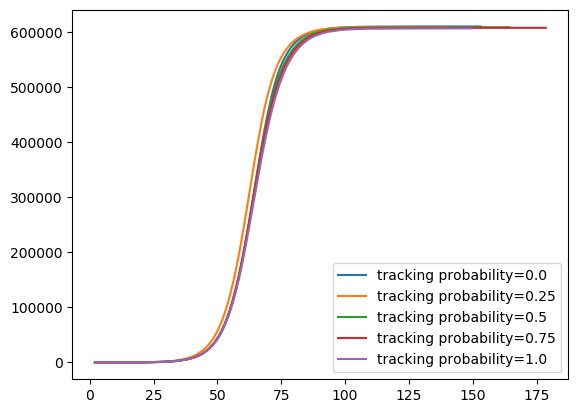

In [87]:
using PyPlot
for (i,datum) in enumerate(plot_data)
    times, points = datum
    plot(times, points, label="tracking probability=$(tracking_probs[i])" )
end
legend()
savefig("tracking_vs_")

In [286]:
state = Simulation.SimState(params.progressions |> length, seed=123)

push!(state.queue, Simulation.Event(Val(Simulation.OutsideInfectionEvent),0.0,1))


@time for iter  in 0:10^7
    #println("iteration=$iter")
    if isempty(state.queue)
        @info "Empty queue after $iter events"
        break
    end
    
    event = pop!(state.queue)
    state.time = Simulation.time(event)
    #println("iter=", iter, " ", event)   
    result = Simulation.execute!(state, params, event)
    
end
#event = pop!(state.queue)
#state.time = Simulation.time(event)
#println(event.event_kind)
#@code_warntype Simulation.execute!(state, params, event)

#event |> display

#id = 0x000781a0
#state.individuals[id]
#Simulation.householdof(params, id) |> collect

 11.282441 seconds (35.76 M allocations: 735.614 MiB, 10.00% gc time)


┌ Info: Empty queue after 8857482 events
└ @ Main In[286]:9


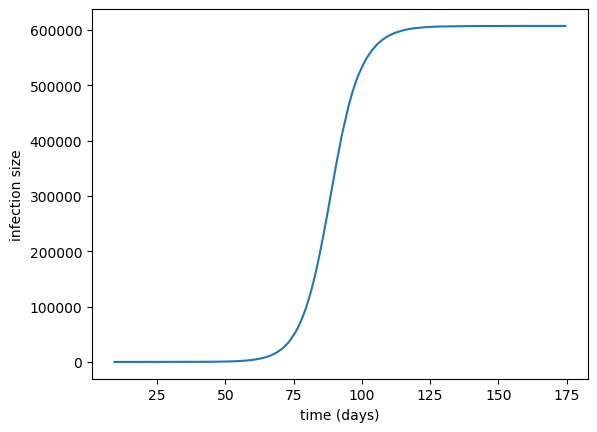

PyObject Text(24.0, 0.5, 'infection size')

In [301]:
using PyPlot
events = vcat(state.infections...)
sort!(events, lt=(x,y)->x.time<y.time)
times = getproperty.(events, :time)
plot(times, 1:length(events))
xlabel("time (days)")
ylabel("infection size")

In [290]:
?sort

search: sort sort! sortperm sortperm! sortslices SortedSet SortedDict



```
sort(v; alg::Algorithm=defalg(v), lt=isless, by=identity, rev::Bool=false, order::Ordering=Forward)
```

Variant of [`sort!`](@ref) that returns a sorted copy of `v` leaving `v` itself unmodified.

# Examples

```jldoctest
julia> v = [3, 1, 2];

julia> sort(v)
3-element Array{Int64,1}:
 1
 2
 3

julia> v
3-element Array{Int64,1}:
 3
 1
 2
```

---

```
sort(A; dims::Integer, alg::Algorithm=DEFAULT_UNSTABLE, lt=isless, by=identity, rev::Bool=false, order::Ordering=Forward)
```

Sort a multidimensional array `A` along the given dimension. See [`sort!`](@ref) for a description of possible keyword arguments.

To sort slices of an array, refer to [`sortslices`](@ref).

# Examples

```jldoctest
julia> A = [4 3; 1 2]
2×2 Array{Int64,2}:
 4  3
 1  2

julia> sort(A, dims = 1)
2×2 Array{Int64,2}:
 1  2
 4  3

julia> sort(A, dims = 2)
2×2 Array{Int64,2}:
 3  4
 1  2
```

---

```
sort(df::AbstractDataFrame, cols;
     alg::Union{Algorithm, Nothing}=nothing, lt=isless, by=identity,
     rev::Bool=false, order::Ordering=Forward)
```

Return a copy of data frame `df` sorted by column(s) `cols`. `cols` can be either a `Symbol` or `Integer` column index, or a tuple or vector of such indices.

If `alg` is `nothing` (the default), the most appropriate algorithm is chosen automatically among `TimSort`, `MergeSort` and `RadixSort` depending on the type of the sorting columns and on the number of rows in `df`. If `rev` is `true`, reverse sorting is performed. To enable reverse sorting only for some columns, pass `order(c, rev=true)` in `cols`, with `c` the corresponding column index (see example below). See [`sort!`](@ref) for a description of other keyword arguments.

# Examples

```jldoctest
julia> df = DataFrame(x = [3, 1, 2, 1], y = ["b", "c", "a", "b"])
4×2 DataFrame
│ Row │ x     │ y      │
│     │ Int64 │ String │
├─────┼───────┼────────┤
│ 1   │ 3     │ b      │
│ 2   │ 1     │ c      │
│ 3   │ 2     │ a      │
│ 4   │ 1     │ b      │

julia> sort(df, :x)
4×2 DataFrame
│ Row │ x     │ y      │
│     │ Int64 │ String │
├─────┼───────┼────────┤
│ 1   │ 1     │ c      │
│ 2   │ 1     │ b      │
│ 3   │ 2     │ a      │
│ 4   │ 3     │ b      │

julia> sort(df, (:x, :y))
4×2 DataFrame
│ Row │ x     │ y      │
│     │ Int64 │ String │
├─────┼───────┼────────┤
│ 1   │ 1     │ b      │
│ 2   │ 1     │ c      │
│ 3   │ 2     │ a      │
│ 4   │ 3     │ b      │

julia> sort(df, (:x, :y), rev=true)
4×2 DataFrame
│ Row │ x     │ y      │
│     │ Int64 │ String │
├─────┼───────┼────────┤
│ 1   │ 3     │ b      │
│ 2   │ 2     │ a      │
│ 3   │ 1     │ c      │
│ 4   │ 1     │ b      │

julia> sort(df, (:x, order(:y, rev=true)))
4×2 DataFrame
│ Row │ x     │ y      │
│     │ Int64 │ String │
├─────┼───────┼────────┤
│ 1   │ 1     │ c      │
│ 2   │ 1     │ b      │
│ 3   │ 2     │ a      │
│ 4   │ 3     │ b      │
```


In [52]:
## creates mutable simulation state
state = Simulation.SimState(params.progressions |> length, seed=123)

# add initial event (infect the person no1 at time 0)
push!(state.queue, Simulation.OutsideInfectionEvent(0.0,1))
# (the first person must be infectious for significant amount of time for the epidemics to kick off)

# the first run includes compilation time, run twice to get meaningful results (precompilation will be added soon)
@time Simulation.simulate!(state, params)


UndefVarError: UndefVarError: params_id not defined

In [279]:
using DataStructures
i1, i2 = searchequalrange(state.infections, 1)
state.infections[i1]


Main.Simulation.TransmissionEvent(18.69558f0, 491936, 1, Main.Simulation.ConstantKernelContact)

In [261]:
@time Vector{Int32}()

  0.000001 seconds (1 allocation: 80 bytes)


0-element Array{Int32,1}

In [265]:
using DataStructures
infections = SortedMultiDict{Int32,Int32}()
@time push!(infections, 0=>1)
@time push!(infections, 1=>2)
@time push!(infections, 1=>3)
@time push!(infections, 2=>4)
@time push!(infections, 3=>5)
@time push!(infections, 3=>6)
@time push!(infections, 4=>4)
@time push!(infections, 4=>5)
@time push!(infections, 4=>6)
for v in inclusive(infections, searchequalrange(infections, 3)...) |> values
    println("$v")
    #println("$k ---> $v")
end

  0.000016 seconds (1 allocation: 80 bytes)
  0.000007 seconds (1 allocation: 176 bytes)
  0.000006 seconds (1 allocation: 144 bytes)
  0.000005 seconds
  0.000004 seconds
  0.000005 seconds (1 allocation: 336 bytes)
  0.000005 seconds (1 allocation: 272 bytes)
  0.000005 seconds
  0.000004 seconds
5
6


In [264]:
inclusive(infections, searchequalrange(infections, 3)...) |> values |> collect

MethodError: MethodError: no method matching length(::DataStructures.SDMValIteration{DataStructures.SDMIncludeLast{SortedMultiDict{Int32,Int32,Base.Order.ForwardOrdering}}})
Closest candidates are:
  length(!Matched::Core.SimpleVector) at essentials.jl:596
  length(!Matched::Base.MethodList) at reflection.jl:852
  length(!Matched::Core.MethodTable) at reflection.jl:938
  ...

In [8]:
inclusive(infections, i1, i2) |> sizeof

24